In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import time
import os
import sys
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader,TensorDataset
import pickle


In [3]:
%matplotlib inline

# CHECK FOR GPUS

In [4]:
torch.cuda.is_available()

False

In [5]:
# Check for available GPUs
if torch.cuda.is_available():
    # Choose the first available GPU
    device = torch.device("cuda")
    # Optionally, print information about each GPU
    num_gpus = torch.cuda.device_count()
    for gpu_id in range(num_gpus):
        print(f"GPU {gpu_id}: {torch.cuda.get_device_name(gpu_id)}")
else:
    # Use the CPU if no GPU is available
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")
device

No GPU available. Using CPU.


device(type='cpu')

# Simulator p(x|$\theta$)

In [6]:
def sg_sim(mu,sigma,nevents):
    """
    mu: global theta (param of interest)
    sigma: global theta_nu (global nuisance)
    x: observed data
    """
    return [np.random.normal(mu,sigma) for i in range(nevents)]
def bg_sim(nevents,mu=4):
    """
    mu: global theta (param of interest)
    sigma: global theta_nu (global nuisance)
    x: observed data
    """
    return np.random.default_rng().exponential(scale=mu, size=nevents)


# Create data set

In [7]:
XRANGE=(0,30)   # range of x or observable range
MIN_WINDOW =2.5 # minimum window size or resolution
NSG=10000
NBG=50000
NBINS=100
YSCALE="linear"
NOISE_TOLERANCE=0.1


def generate_data(mean,sigma,nsg=NSG,nbg=NBG):
    sg=sg_sim(mean,sigma,nsg)
    bg=bg_sim(nbg)
    return sg, bg

def ensemble_data(sg,bg,xrange=XRANGE,nbins=NBINS,yscale=YSCALE,plot=False):
    hist_1, _ = np.histogram(sg, bins=nbins, range=xrange)
    hist_2, _ = np.histogram(bg, bins=nbins, range=xrange)
    hist_both = hist_1+hist_2

    if yscale =="log":
        hist_both,_ = np.histogram(np.append(sg,bg), bins=nbins, range=xrange)
        hist_1 = np.log1p(hist_1)
        hist_2 = np.log1p(hist_2)
        hist_both = np.log1p(hist_both)

    if plot:
            plt.hist([sg,bg],bins=nbins,alpha=0.4,color=["g","b"],label=["sg","bg"],range=xrange,stacked=True)
            plt.yscale(yscale)
            plt.xlim(xrange)
            if yscale =="log":
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),np.exp(hist_both),alpha=1)
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),np.exp(hist_1),alpha=1)
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),np.exp(hist_2),alpha=1)
            else:
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),(hist_both),alpha=1)
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),(hist_1),alpha=1)
                plt.plot(np.arange(xrange[0],xrange[1],(xrange[1]-xrange[0])/nbins),(hist_2),alpha=1)
            plt.title(str(xrange))
            plt.show()
            
            
    return hist_1, hist_2, hist_both

def generate_cuts(xrange,min_window):
    cuts_list=[]

    # include maximum range
    cuts_list.append(xrange)
    
    # Calcuate how many slices can be made
    k=(xrange[1]-xrange[0])/min_window

    # Generate cuts
    for isize in range(1,int(k)):
        krange_0 = xrange[0]
        while krange_0+isize*min_window <= xrange[1]:
            cuts_list.append([krange_0,krange_0+isize*min_window])
            krange_0 = krange_0+min_window
    return cuts_list



In [8]:
CUTS = generate_cuts(XRANGE,MIN_WINDOW)
print(len(CUTS))


78


# Generate dataset systematically

In [9]:
MEAN = np.arange(2,28+0.1,3)#0.5)
SIGMA = np.arange(1,5+0.1,0.5)#0.5)


In [10]:

dat_mr = []        # Data with maximum range
dat_mr_aug = []    # Data with maximum range with augmentation           
dat_randaug = []   # Data with random augmentation           
dat_all =  []      # Data with all augmentation

dat_mr_log = []        # Data with maximum range log
dat_mr_aug_log = []    # Data with maximum range with augmentation            log
dat_randaug_log = []   # Data with random augmentation            log
dat_all_log =  []      # Data with all augmentation log


dat_mr_aug_in = []    # Data with maximum range with augmentation           
dat_randaug_in = []   # Data with random augmentation           
dat_all_in =  []      # Data with all augmentation

dat_mr_aug_log_in = []    # Data with maximum range with augmentation            log
dat_randaug_log_in = []   # Data with random augmentation            log
dat_all_log_in =  []      # Data with all augmentation log

n=0
print("------Generate dataset systematically------")
for mean,sigma in itertools.product(MEAN,SIGMA):
    print(".",end="")
    sg,bg = generate_data(mean,sigma)

    # Systematic augmentation
    for icuts in CUTS:

        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*sigma <= mean and  mean <= icuts[1]+3*sigma :
            
            data = ensemble_data(sg,bg,yscale="linear",xrange=icuts)
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            if icuts == XRANGE:
                dat_mr.append([mean,sigma,*data])
            dat_mr_aug.append([mean,sigma,icuts,*data])
            dat_all.append([mean,sigma,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)

        if  icuts[0] <= mean-sigma and  mean+sigma <= icuts[1] :
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            dat_mr_aug_in.append([mean,sigma,icuts,*data])
            dat_all_in.append([mean,sigma,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)
    
    for icuts in CUTS:

        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*sigma <= mean and  mean <= icuts[1]+3*sigma :
            
            data = ensemble_data(sg,bg,yscale="log",xrange=icuts)
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            if icuts == XRANGE:
                dat_mr_log.append([mean,sigma,*data])
            dat_mr_aug_log.append([mean,sigma,icuts,*data])
            dat_all_log.append([mean,sigma,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)

        if  icuts[0] <= mean-sigma and  mean+sigma <= icuts[1] :
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            dat_mr_aug_log_in.append([mean,sigma,icuts,*data])
            dat_all_log_in.append([mean,sigma,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)
    
    
    # Generate random cuts
    rand_cuts = [(np.random.uniform(0,30),np.random.uniform(0,30)) for i in range(len(CUTS))]
    rand_cuts = [i for i in rand_cuts if (i[0] < i[1] and i[1]-i[0] > MIN_WINDOW)]
    
    # Random augmentation
    for icuts in rand_cuts:
        
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*sigma <= mean and  mean <= icuts[1]+3*sigma :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="linear",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            dat_randaug.append([mean,sigma,icuts,*data])
            dat_all.append([mean,sigma,icuts,*data])
        if  icuts[0] <= mean-sigma and  mean+sigma <= icuts[1] :
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            dat_randaug_in.append([mean,sigma,icuts,*data])
            dat_all_in.append([mean,sigma,icuts,*data])

    for icuts in rand_cuts:
        
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*sigma <= mean and  mean <= icuts[1]+3*sigma :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="log",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            dat_randaug_log.append([mean,sigma,icuts,*data])
            dat_all_log.append([mean,sigma,icuts,*data])

        if  icuts[0] <= mean-sigma and  mean+sigma <= icuts[1] :
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            dat_randaug_log_in.append([mean,sigma,icuts,*data])
            dat_all_log_in.append([mean,sigma,icuts,*data])



------Generate dataset systematically------
..

................................5000
...........................10000
....................

In [11]:

print()
print(n)
print("lin    : Systematically generated data with maximum range                            (for training)  :",len(dat_mr))
print("log    : Systematically generated data with maximum range                            (for training)  :",len(dat_mr_log))

print("lin+out: Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(dat_mr_aug))
print("lin+out: Systematically generated data with random augmentation                      (for testing )  :",len(dat_randaug))
print("lin+out: Systematically generated data with all                                      (for testing )  :",len(dat_all))

print("log+out: Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(dat_mr_aug_log))
print("log+out: Systematically generated data with random augmentation                      (for testing )  :",len(dat_randaug_log))
print("log+out: Systematically generated data with all                                      (for testing )  :",len(dat_all_log))


print("lin+in : Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(dat_mr_aug_in))
print("lin+in : Systematically generated data with random augmentation                      (for testing )  :",len(dat_randaug_in))
print("lin+in : Systematically generated data with all                                      (for testing )  :",len(dat_all_in))

print("log+in : Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(dat_mr_aug_log_in))
print("log+in : Systematically generated data with random augmentation                      (for testing )  :",len(dat_randaug_log_in))
print("log+in : Systematically generated data with all                                      (for testing )  :",len(dat_all_log_in))



13042
lin    : Systematically generated data with maximum range                            (for training)  : 81
log    : Systematically generated data with maximum range                            (for training)  : 81
lin+out: Systematically generated data with maximum range + systematic augmentation  (for training)  : 4916
lin+out: Systematically generated data with random augmentation                      (for testing )  : 2078
lin+out: Systematically generated data with all                                      (for testing )  : 6994
log+out: Systematically generated data with maximum range + systematic augmentation  (for training)  : 4916
log+out: Systematically generated data with random augmentation                      (for testing )  : 2078
log+out: Systematically generated data with all                                      (for testing )  : 6994
lin+in : Systematically generated data with maximum range + systematic augmentation  (for training)  : 1605
lin+in : Systematically g

# Generate dataset randomly

In [12]:
rand_dat_mr = []
rand_dat_mr_aug = []
rand_dat_randaug = []
rand_dat_all = []

rand_dat_mr_log = []
rand_dat_mr_aug_log = []
rand_dat_randaug_log = []
rand_dat_all_log = []

rand_dat_mr_aug_in = []
rand_dat_randaug_in = []
rand_dat_all_in = []

rand_dat_mr_aug_log_in = []
rand_dat_randaug_log_in = []
rand_dat_all_log_in = []

n=0
n_rand = 0

# Randomly generate mu and iis
rand_dat_mu_sig = [(np.random.uniform(2.0, 28.0),np.random.uniform(1.0, 5.0)) for i in range(len(list(itertools.product(MEAN,SIGMA))))]

print("------Generate dataset randomly------")
for iim,iis in rand_dat_mu_sig:
    
    print(".",end="")
    sg,bg = generate_data(iim,iis)
    
    
    # Systematic augmentation
    for icuts in CUTS:
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*iis <= iim and  iim <= icuts[1]+3*iis :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="linear",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            rand_dat_mr_aug.append([iim,iis,icuts,*data])
            rand_dat_all.append([iim,iis,icuts,*data])
            if icuts == XRANGE:
                rand_dat_mr.append([iim,iis,*data])
            
            n+=1    
            if n % 5000 == 0:
                print(n,iim,iis,icuts)
        if  icuts[0] <= iim-iis and  iim+iis <= icuts[1] :
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            rand_dat_mr_aug_in.append([iim,iis,icuts,*data])
            rand_dat_all_in.append([iim,iis,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)
    
    # Systematic augmentation
    for icuts in CUTS:
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*iis <= iim and  iim <= icuts[1]+3*iis :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="log",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            rand_dat_mr_aug_log.append([iim,iis,icuts,*data])
            rand_dat_all_log.append([iim,iis,icuts,*data])
            if icuts == XRANGE:
                rand_dat_mr_log.append([iim,iis,*data])
            
            n+=1    
            if n % 5000 == 0:
                print(n,iim,iis,icuts)
        
        if  icuts[0] <= iim-iis and  iim+iis <= icuts[1] :
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            rand_dat_mr_aug_log_in.append([iim,iis,icuts,*data])
            rand_dat_all_log_in.append([iim,iis,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)        
    
    # Generate random cuts
    rand_cuts = [(np.random.uniform(0,30),np.random.uniform(0,30)) for i in range(len(CUTS))]
    rand_cuts = [i for i in rand_cuts if (i[0] < i[1] and i[1]-i[0] > MIN_WINDOW)]
    
    # Random augmentation
    for icuts in rand_cuts:
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*iis <= iim and  iim <= icuts[1]+3*iis :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="linear",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            rand_dat_randaug.append([iim,iis,icuts,*data])
            rand_dat_all.append([iim,iis,icuts,*data])
            n_rand += 1
            
            n+=1   
            if n % 5000 == 0:
                print(n,iim,iis,icuts)

        if  icuts[0] <= iim-iis and  iim+iis <= icuts[1] :
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue

            rand_dat_randaug_in.append([iim,iis,icuts,*data])
            rand_dat_all_in.append([iim,iis,icuts,*data])

            n+=1     
            if n % 5000 == 0:
                print(n)

    # Random augmentation
    for icuts in rand_cuts:
        # check if the cuts are close to the range of the signal
        if  icuts[0]-3*iis <= iim and  iim <= icuts[1]+3*iis :
            data = ensemble_data(sg,bg,xrange=icuts,yscale="log",plot=False)
            
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            rand_dat_randaug_log.append([iim,iis,icuts,*data])
            rand_dat_all_log.append([iim,iis,icuts,*data])
            n_rand += 1
            
            n+=1   
            if n % 5000 == 0:
                print(n,iim,iis,icuts)
                
        if  icuts[0] <= iim-iis and  iim+iis <= icuts[1] :
            # check if the data is too noisy or not
            if len([i for i in data[-1] if i==0])/len(data[-1]) > NOISE_TOLERANCE:
                continue
            
            rand_dat_randaug_log_in.append([iim,iis,icuts,*data])
            rand_dat_all_log_in.append([iim,iis,icuts,*data])


#print("n                       :",n)
#print("Randomly generated data with maximum range                            (for testing ) :",len(rand_dat_mr))
#print("Randomly generated data with maximum range + systematic augmentation  (for testing ) :",len(rand_dat_mr_aug))
#print("Randomly generated data with random augmentation                      (for testing ) :",len(rand_dat_randaug))
#print("Randomly generated data with all possibility                          (for testing ) :",len(rand_dat_all),len(rand_dat_mr_aug)+len(rand_dat_randaug))
#print("Randomly generated data with maximum range                            (for testing ) :",len(rand_dat_mr_log))
#print("Randomly generated data with maximum range + systematic augmentation  (for testing ) :",len(rand_dat_mr_aug_log))
#print("Randomly generated data with random augmentation                      (for testing ) :",len(rand_dat_randaug_log))
#print("Randomly generated data with all possibility                          (for testing ) :",len(rand_dat_all_log),len(rand_dat_mr_aug_log)+len(rand_dat_randaug_log))
print()
print(n)
print("lin    : Systematically generated data with maximum range                            (for training)  :",len(rand_dat_mr))
print("log    : Systematically generated data with maximum range                            (for training)  :",len(rand_dat_mr_log))

print("lin+out: Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(rand_dat_mr_aug))
print("lin+out: Systematically generated data with random augmentation                      (for testing )  :",len(rand_dat_randaug))
print("lin+out: Systematically generated data with all                                      (for testing )  :",len(rand_dat_all))

print("log+out: Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(rand_dat_mr_aug_log))
print("log+out: Systematically generated data with random augmentation                      (for testing )  :",len(rand_dat_randaug_log))
print("log+out: Systematically generated data with all                                      (for testing )  :",len(rand_dat_all_log))


print("lin+in : Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(rand_dat_mr_aug_in))
print("lin+in : Systematically generated data with random augmentation                      (for testing )  :",len(rand_dat_randaug_in))
print("lin+in : Systematically generated data with all                                      (for testing )  :",len(rand_dat_all_in))

print("log+in : Systematically generated data with maximum range + systematic augmentation  (for training)  :",len(rand_dat_mr_aug_log_in))
print("log+in : Systematically generated data with random augmentation                      (for testing )  :",len(rand_dat_randaug_log_in))
print("log+in : Systematically generated data with all                                      (for testing )  :",len(rand_dat_all_log_in))



------Generate dataset randomly------
.

....................5000 23.247466964911503 2.2346124876459403 (19.115342633913876, 28.346487338135194)
......................10000
.......................15000 20.29527139101594 2.501068733955286 (9.256345097868069, 19.27304254690259)
...............
18275
lin    : Systematically generated data with maximum range                            (for training)  : 81
log    : Systematically generated data with maximum range                            (for training)  : 81
lin+out: Systematically generated data with maximum range + systematic augmentation  (for training)  : 5081
lin+out: Systematically generated data with random augmentation                      (for testing )  : 2186
lin+out: Systematically generated data with all                                      (for testing )  : 7267
log+out: Systematically generated data with maximum range + systematic augmentation  (for training)  : 5081
log+out: Systematically generated data with random augmentation                      (for testing 

# Visualizing data distribution

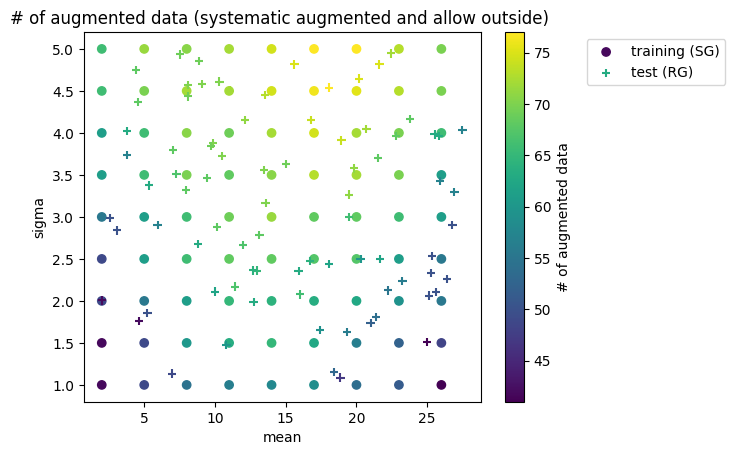

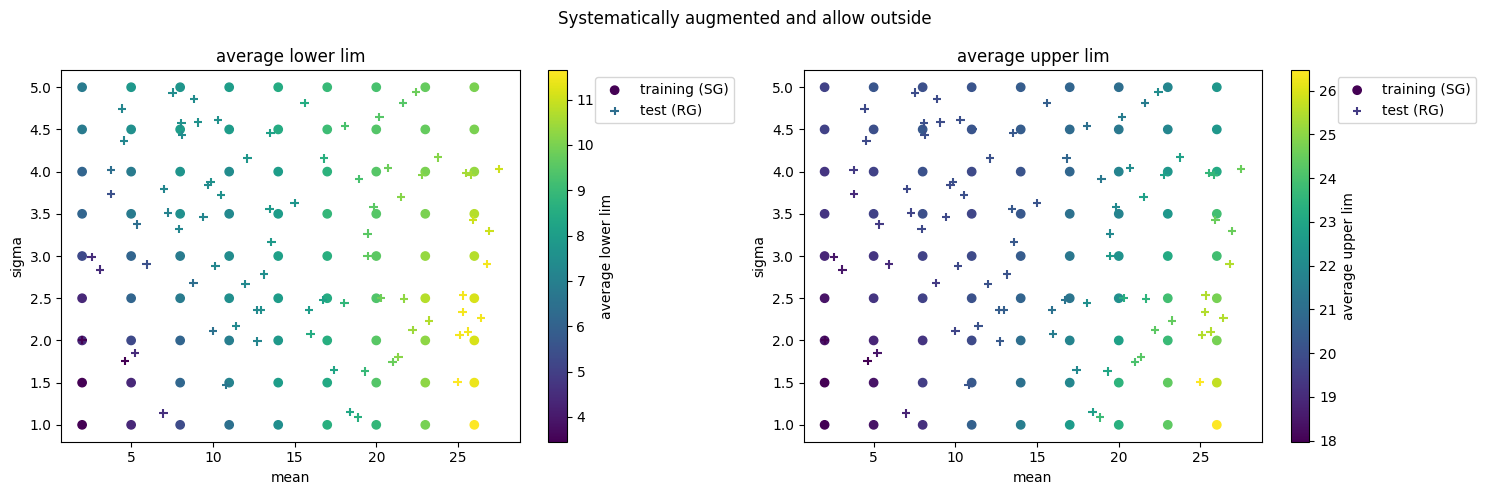

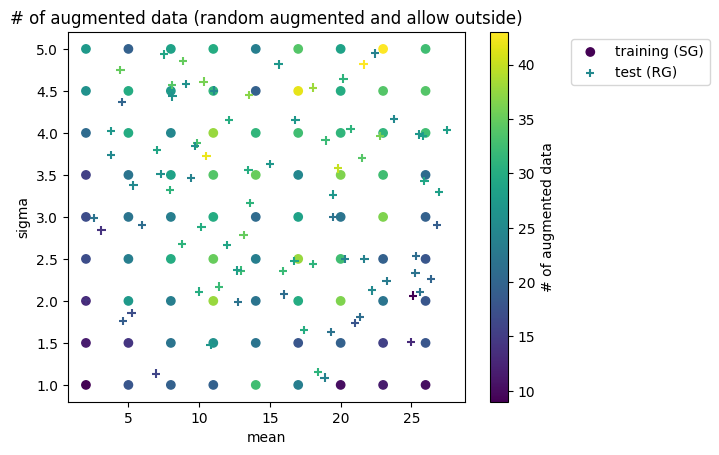

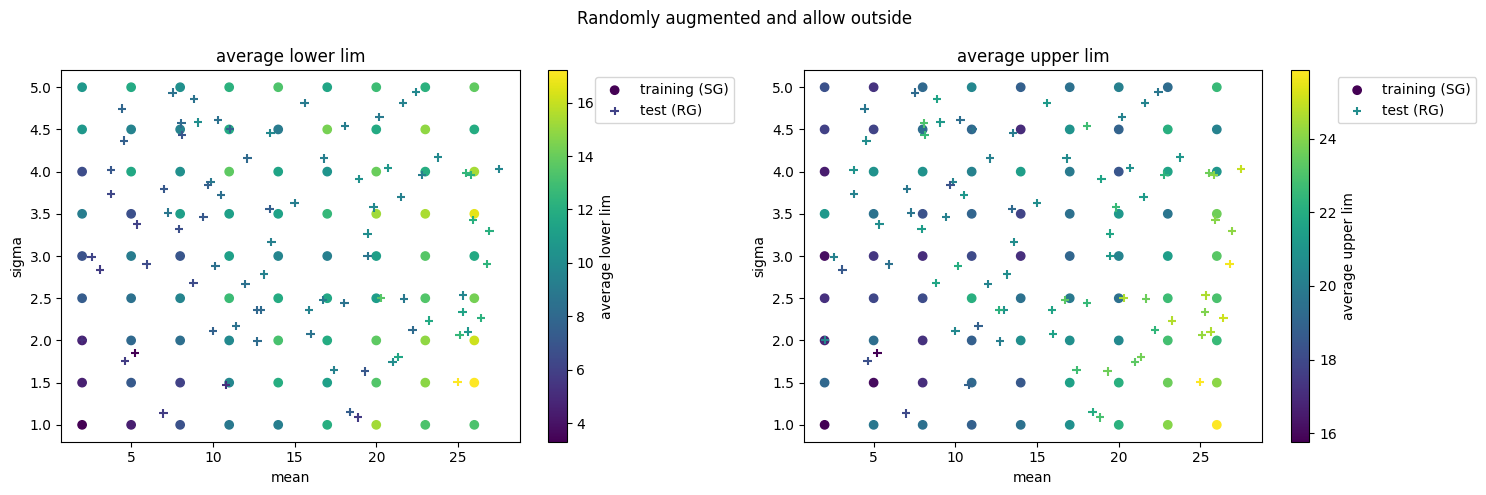

In [13]:
dat_distribution = []
dat_distribution_rand = []
test_distribution = []
test_distribution_rand = []


for mean,sigma in itertools.product(MEAN,SIGMA):
    iiicuts = [i[2] for i in dat_mr_aug if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    dat_distribution.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])

for mean,sigma in itertools.product(MEAN,SIGMA):
    iiicuts = [i[2] for i in dat_randaug if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        dat_distribution_rand.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

for mean,sigma in rand_dat_mu_sig:
    iiicuts = [i[2] for i in rand_dat_mr_aug if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    test_distribution.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])

for mean,sigma in rand_dat_mu_sig:
    iiicuts = [i[2] for i in rand_dat_randaug if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        test_distribution_rand.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

m_d  , s_d  , l_d   , lc_d  , uc_d   = np.transpose(dat_distribution)   # sys aug
m_t  , s_t  , l_t   , lc_t  , uc_t   = np.transpose(test_distribution)  # sys aug

m_dr , s_dr , l_dr  , lc_dr , uc_dr  = np.transpose(dat_distribution_rand) # rand aug
m_tr , s_tr , l_tr  , lc_tr , uc_tr  = np.transpose(test_distribution_rand) # rand aug

fig, ax = plt.subplots()

plt.scatter(m_d  , s_d  , c=l_d  , cmap='viridis', marker='o',label="training (SG)")    
plt.scatter(m_t  , s_t  , c=l_t  , cmap='viridis', marker='+',label="test (RG)")    
plt.xlabel('mean')
plt.ylabel('sigma')
plt.title('# of augmented data (systematic augmented and allow outside) ')
plt.colorbar(label='# of augmented data')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1s = ax1.scatter(m_d  , s_d  , c=lc_d  , cmap='viridis', marker='o',label="training (SG)")    
ax1s = ax1.scatter(m_t  , s_t  , c=lc_t  , cmap='viridis', marker='+',label="test (RG)")    
ax1.set_xlabel('mean')
ax1.set_ylabel('sigma')
ax1.set_title('average lower lim')
fig.colorbar(ax1s,label='average lower lim',ax=ax1)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
ax2s = ax2.scatter(m_d  , s_d  , c=uc_d  , cmap='viridis', marker='o',label="training (SG)")    
ax2s = ax2.scatter(m_t  , s_t  , c=uc_t  , cmap='viridis', marker='+',label="test (RG)")    
ax2.set_xlabel('mean')
ax2.set_ylabel('sigma')
ax2.set_title('average upper lim')
fig.colorbar(ax2s,label='average upper lim',ax=ax2)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.suptitle('Systematically augmented and allow outside')
plt.tight_layout()
plt.show()

plt.scatter(m_dr , s_dr , c=l_dr , cmap='viridis', marker='o',label="training (SG)")        
plt.scatter(m_tr , s_tr , c=l_tr , cmap='viridis', marker='+',label="test (RG)")        
plt.xlabel('mean')
plt.ylabel('sigma')
plt.title('# of augmented data (random augmented and allow outside)')
plt.colorbar(label='# of augmented data')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1s = ax1.scatter(m_dr  , s_dr  , c=lc_dr  , cmap='viridis', marker='o',label="training (SG)")    
ax1s = ax1.scatter(m_tr  , s_tr  , c=lc_tr  , cmap='viridis', marker='+',label="test (RG)")    
ax1.set_xlabel('mean')
ax1.set_ylabel('sigma')
ax1.set_title('average lower lim')
fig.colorbar(ax1s,label='average lower lim',ax=ax1)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
ax2s = ax2.scatter(m_dr  , s_dr  , c=uc_dr  , cmap='viridis', marker='o',label="training (SG)")    
ax2s = ax2.scatter(m_tr  , s_tr  , c=uc_tr  , cmap='viridis', marker='+',label="test (RG)")    
ax2.set_xlabel('mean')
ax2.set_ylabel('sigma')
ax2.set_title('average upper lim')
fig.colorbar(ax2s,label='average upper lim',ax=ax2)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.suptitle('Randomly augmented and allow outside')
plt.tight_layout()
plt.show()

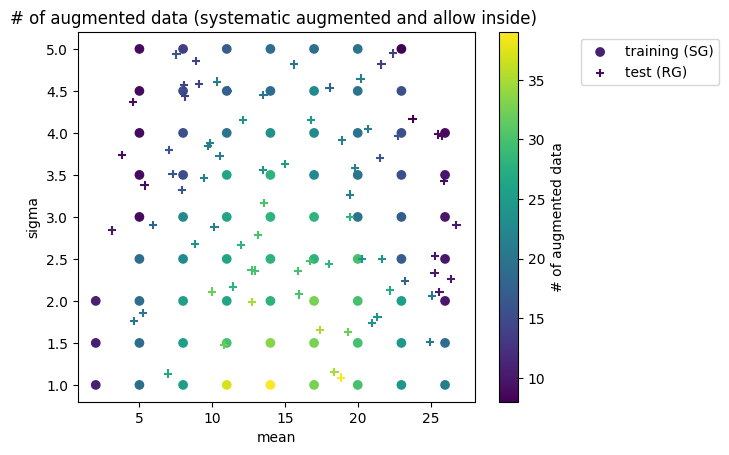

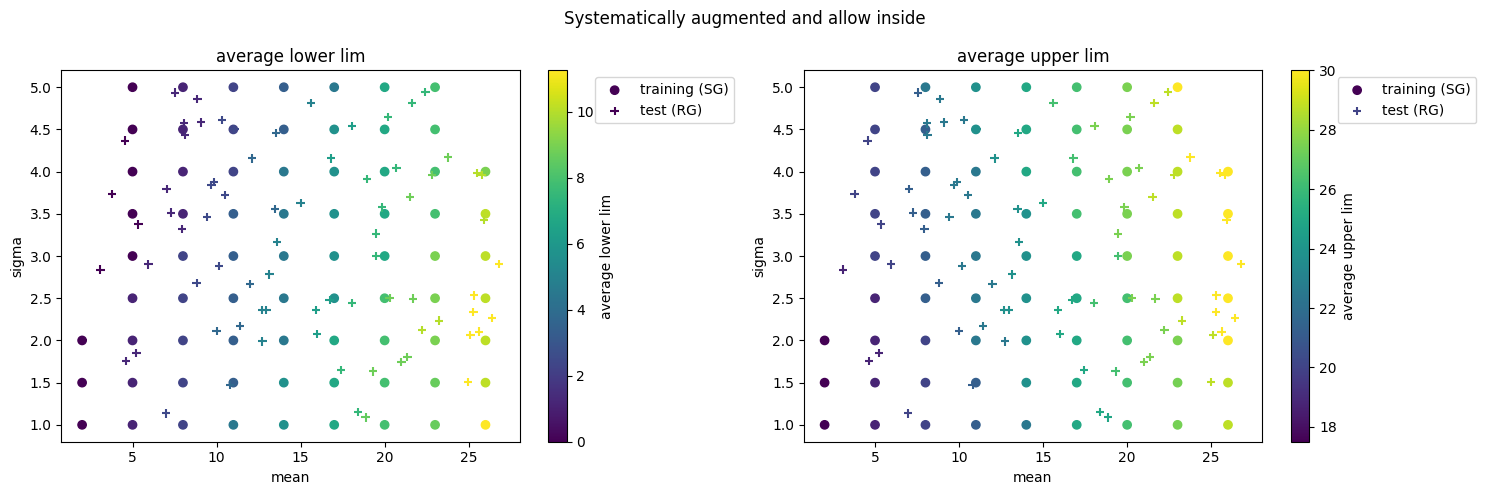

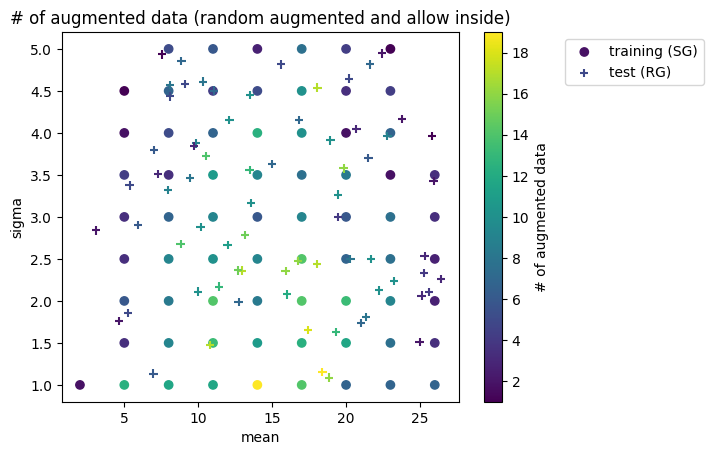

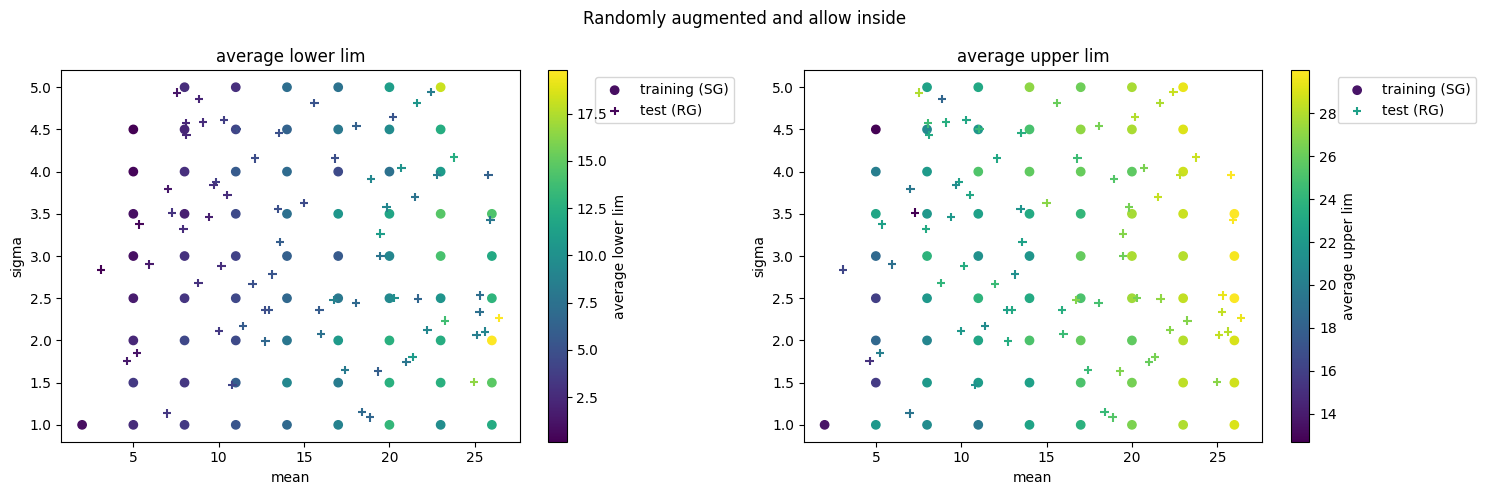

In [14]:
dat_distribution = []
dat_distribution_rand = []
test_distribution = []
test_distribution_rand = []


for mean,sigma in itertools.product(MEAN,SIGMA):
    iiicuts = [i[2] for i in dat_mr_aug_in if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        dat_distribution.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

for mean,sigma in itertools.product(MEAN,SIGMA):
    iiicuts = [i[2] for i in dat_randaug_in if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        dat_distribution_rand.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

for mean,sigma in rand_dat_mu_sig:
    iiicuts = [i[2] for i in rand_dat_mr_aug_in if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        test_distribution.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

for mean,sigma in rand_dat_mu_sig:
    iiicuts = [i[2] for i in rand_dat_randaug_in if i[0] == mean and i[1] == sigma]
    tiiicuts = np.transpose(iiicuts)
    try:
        test_distribution_rand.append([mean,sigma,len(iiicuts),tiiicuts[0].mean(),tiiicuts[1].mean()])
    except:
        continue

m_d  , s_d  , l_d   , lc_d  , uc_d   = np.transpose(dat_distribution)
m_dr , s_dr , l_dr  , lc_dr , uc_dr  = np.transpose(dat_distribution_rand)
m_t  , s_t  , l_t   , lc_t  , uc_t   = np.transpose(test_distribution)
m_tr , s_tr , l_tr  , lc_tr , uc_tr  = np.transpose(test_distribution_rand)



m_d  , s_d  , l_d   , lc_d  , uc_d   = np.transpose(dat_distribution)   # sys aug
m_t  , s_t  , l_t   , lc_t  , uc_t   = np.transpose(test_distribution)  # sys aug

m_dr , s_dr , l_dr  , lc_dr , uc_dr  = np.transpose(dat_distribution_rand) # rand aug
m_tr , s_tr , l_tr  , lc_tr , uc_tr  = np.transpose(test_distribution_rand) # rand aug

plt.scatter(m_d  , s_d  , c=l_d  , cmap='viridis', marker='o',label="training (SG)")    
plt.scatter(m_t  , s_t  , c=l_t  , cmap='viridis', marker='+',label="test (RG)")    
plt.xlabel('mean')
plt.ylabel('sigma')
plt.title('# of augmented data (systematic augmented and allow inside) ')
plt.colorbar(label='# of augmented data')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1s = ax1.scatter(m_d  , s_d  , c=lc_d  , cmap='viridis', marker='o',label="training (SG)")    
ax1s = ax1.scatter(m_t  , s_t  , c=lc_t  , cmap='viridis', marker='+',label="test (RG)")    
ax1.set_xlabel('mean')
ax1.set_ylabel('sigma')
ax1.set_title('average lower lim')
fig.colorbar(ax1s,label='average lower lim',ax=ax1)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
ax2s = ax2.scatter(m_d  , s_d  , c=uc_d  , cmap='viridis', marker='o',label="training (SG)")    
ax2s = ax2.scatter(m_t  , s_t  , c=uc_t  , cmap='viridis', marker='+',label="test (RG)")    
ax2.set_xlabel('mean')
ax2.set_ylabel('sigma')
ax2.set_title('average upper lim')
fig.colorbar(ax2s,label='average upper lim',ax=ax2)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.suptitle('Systematically augmented and allow inside')
plt.tight_layout()

plt.show()

plt.scatter(m_dr , s_dr , c=l_dr , cmap='viridis', marker='o',label="training (SG)")        
plt.scatter(m_tr , s_tr , c=l_tr , cmap='viridis', marker='+',label="test (RG)")        
plt.xlabel('mean')
plt.ylabel('sigma')
plt.title('# of augmented data (random augmented and allow inside)')
plt.colorbar(label='# of augmented data')
plt.legend(bbox_to_anchor=(1.25, 1), loc='upper left')
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1s = ax1.scatter(m_dr  , s_dr  , c=lc_dr  , cmap='viridis', marker='o',label="training (SG)")    
ax1s = ax1.scatter(m_tr  , s_tr  , c=lc_tr  , cmap='viridis', marker='+',label="test (RG)")    
ax1.set_xlabel('mean')
ax1.set_ylabel('sigma')
ax1.set_title('average lower lim')
fig.colorbar(ax1s,label='average lower lim',ax=ax1)
ax1.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
ax2s = ax2.scatter(m_dr  , s_dr  , c=uc_dr  , cmap='viridis', marker='o',label="training (SG)")    
ax2s = ax2.scatter(m_tr  , s_tr  , c=uc_tr  , cmap='viridis', marker='+',label="test (RG)")    
ax2.set_xlabel('mean')
ax2.set_ylabel('sigma')
ax2.set_title('average upper lim')
fig.colorbar(ax2s,label='average upper lim',ax=ax2)
ax2.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.suptitle('Randomly augmented and allow inside')
plt.tight_layout()

plt.show()



# Data cleaning and preprocessing

# DEFINE MYDATA CLASS

In [15]:
seed_value = 42

In [16]:
class MyData():
    def __init__(self, data,vsize=0.2,batch_size=None, shuffle=True,is_mr=False):
        self.data        = data
        self.feature     = self.get_features()
        self.labels      = self.get_labels()
        self.cuts        = self.get_cuts()
        self.nevents     = self.get_nevents()
        self.aux         = self.get_aux()
        self.vsize = vsize
        self.shuffle = shuffle
        self.neventmax  = None
        if batch_size == None:
            if int(len(self.feature)/100)  > 32:
                batch_size = 2*round(int(len(self.feature)/100)/2 )
            else:
                batch_size =32
        
        while batch_size > len(data):
            print("b.")
            batch_size = int(batch_size/2)
            
        self.batch_size = batch_size

        if len(self.feature) != len(self.labels): raise ValueError
        if len(self.feature) == 0: raise ValueError


        self.global_min, self.global_max                                         = self.get_global_norm()    
        self.norm_feature_g                                                      = self.normalize(self.feature,norm="global")
        self.norm_feature_l                                                      = self.normalize(self.feature,norm="local")
        self.norm_cuts                                                           = self.normalize_cuts(self.cuts)
        self.norm_nevents                                                        = self.normalize_nevents(self.nevents)
        self.norm_aux                                                            = self.normalize_aux(self.aux)

        
        self.train_feat_g, self.valid_feat_g,  self.train_cuts_g , self.valid_cuts_g ,self.train_aux_g , self.valid_aux_g ,  self.train_lab_g, self.valid_lab_g = train_test_split(self.norm_feature_g, self.norm_cuts, self.norm_aux, self.labels, test_size=vsize,shuffle=shuffle,random_state=seed_value)
        self.train_feat_l, self.valid_feat_l,  self.train_cuts_l , self.valid_cuts_l ,self.train_aux_l , self.valid_aux_l ,  self.train_lab_l, self.valid_lab_l = train_test_split(self.norm_feature_l, self.norm_cuts, self.norm_aux, self.labels, test_size=vsize,shuffle=shuffle,random_state=seed_value)

        self.tsr_norm_feature_g     = torch.DoubleTensor(self.norm_feature_g).to(device)
        self.tsr_norm_feature_l     = torch.DoubleTensor(self.norm_feature_l).to(device)
        self.tsr_norm_cuts          = torch.DoubleTensor(self.norm_cuts).to(device)
        self.tsr_norm_nevents       = torch.DoubleTensor(self.norm_nevents).to(device)
        self.tsr_norm_aux           = torch.DoubleTensor(self.norm_aux).to(device)
        self.tsr_labels             = torch.DoubleTensor(self.labels).to(device)
        
        self.tsr_train_feat_g       = torch.DoubleTensor(self.train_feat_g).to(device)
        self.tsr_valid_feat_g       = torch.DoubleTensor(self.valid_feat_g).to(device)
        self.tsr_train_cuts_g       = torch.DoubleTensor(self.train_cuts_g).to(device)
        self.tsr_valid_cuts_g       = torch.DoubleTensor(self.valid_cuts_g).to(device)
        self.tsr_train_lab_g        = torch.DoubleTensor(self.train_lab_g).to(device)
        self.tsr_valid_lab_g        = torch.DoubleTensor(self.valid_lab_g).to(device)
        self.tsr_train_aux_g        = torch.DoubleTensor(self.train_aux_g).to(device)
        self.tsr_valid_aux_g        = torch.DoubleTensor(self.valid_aux_g).to(device)


        self.tsr_train_feat_l       = torch.DoubleTensor(self.train_feat_l).to(device)
        self.tsr_valid_feat_l       = torch.DoubleTensor(self.valid_feat_l).to(device)
        self.tsr_train_cuts_l       = torch.DoubleTensor(self.train_cuts_l).to(device)
        self.tsr_valid_cuts_l       = torch.DoubleTensor(self.valid_cuts_l).to(device)
        self.tsr_train_lab_l        = torch.DoubleTensor(self.train_lab_l).to(device)
        self.tsr_valid_lab_l        = torch.DoubleTensor(self.valid_lab_l).to(device)

        self.tsr_train_aux_l        = torch.DoubleTensor(self.train_aux_l ).to(device)
        self.tsr_valid_aux_l        = torch.DoubleTensor(self.valid_aux_l).to(device)

        self.dataset_g              = TensorDataset(self.tsr_train_feat_g,self.tsr_train_lab_g)
        self.loader_g               = DataLoader(self.dataset_g, batch_size=self.batch_size, shuffle=shuffle)

        self.dataset_l              = TensorDataset(self.tsr_train_feat_l,self.tsr_train_lab_l)
        self.loader_l               = DataLoader(self.dataset_l, batch_size=self.batch_size, shuffle=shuffle)

        self.dataset_g_wcuts        = TensorDataset(self.tsr_train_feat_g,self.tsr_train_cuts_g,self.tsr_train_lab_g)
        self.loader_g_wcuts         = DataLoader(self.dataset_g_wcuts, batch_size=self.batch_size, shuffle=shuffle)

        self.dataset_l_wcuts        = TensorDataset(self.tsr_train_feat_l,self.tsr_train_cuts_l,self.tsr_train_lab_l)
        self.loader_l_wcuts         = DataLoader(self.dataset_l_wcuts, batch_size=self.batch_size, shuffle=shuffle)
        
        self.dataset_g_waux        = TensorDataset(self.tsr_train_feat_g,self.tsr_train_aux_g,self.tsr_train_lab_g)
        self.loader_g_waux         = DataLoader(self.dataset_g_waux, batch_size=self.batch_size, shuffle=shuffle)

        self.dataset_l_waux        = TensorDataset(self.tsr_train_feat_l,self.tsr_train_aux_l,self.tsr_train_lab_l)
        self.loader_l_waux         = DataLoader(self.dataset_l_waux, batch_size=self.batch_size, shuffle=shuffle)
        
        if not is_mr:
            self.get_mr()

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def get_features(self):
        feat = np.array([item[-1] for item in self.data]).astype(float)
        feat = feat.reshape(len(feat), 1, NBINS)
        return feat
    
    def get_labels(self):
        lab = np.array([item[:2] for item in self.data]).astype(float)
        lab   = lab.reshape(len(lab),2)
        return lab

    def get_cuts(self):
        cuts = np.array([item[-4] for item in self.data]).astype(float)
        return cuts

    def get_nevents(self):
        nevents = np.array([np.sum(item[-1]) for item in self.data]).astype(float)
        return nevents

    def get_aux(self):
        aux = np.array([(*item[-4],np.sum(item[-1])) for item in self.data]).astype(float)
        return aux
        

    def normalize_cuts(self,cut_dat):
        cut_dat = np.array([(cuts/XRANGE[-1]) for cuts in cut_dat]).astype(float)
        cut_dat = cut_dat.reshape(len(cut_dat), 1, 2)
        return cut_dat
    
    def normalize_nevents(self,nevents_dat):
        if self.neventmax == None:
            self.neventmax = max(np.array([np.sum(item[-1]) for item in self.data]).astype(float))
        nevents_dat = np.array([(nevents/self.neventmax) for nevents in nevents_dat]).astype(float)
        return nevents_dat
    
    def normalize_aux(self,aux_dat):
        if self.neventmax == None:
            self.neventmax = max(np.array([np.sum(item[-1]) for item in self.data]).astype(float))
        aux_dat = np.array([(cuts_l/XRANGE[-1],cuts_u/XRANGE[-1],nevents/self.neventmax) for cuts_l,cuts_u,nevents in aux_dat]).astype(float)
        return aux_dat




    def get_global_norm(self):
        self.global_min = np.min([np.min(image) for image in self.feature])
        self.global_max = np.max([np.max(image) for image in self.feature])
        return self.global_min,self.global_max

    def normalize(self,indat=None,norm=None):
        if type(indat) == type(None): indat = self.feature
        assert norm in ["global","local"]
        if norm == "local":
            return np.array([(image - np.min(image)) / (np.max(image) - np.min(image)) for image in indat]).astype(float)
        if norm == "global":
            return np.array([(image - self.global_min) / (self.global_max - self.global_min) for image in indat]).astype(float)
    
    def get_mr(self):
        self.data_mr = ([item for item in self.data if item[-4] == (0,30)])
        
        if len(self.data_mr) > 1:
            self.mr = MyData(self.data_mr,vsize=self.vsize,batch_size=self.batch_size, shuffle=self.shuffle,is_mr=True)

In [17]:
data_dict = {}
data_dict["LIN:S_MR+SAUG"]             = MyData(dat_mr_aug,batch_size=512)          # S:MR+SAUG      # Systematically generated data: MAX RANGE + Systematic augmentation   
data_dict["LIN:S_RAUG"]                = MyData(dat_randaug,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation
data_dict["LIN:S_MR+SAUG+RAUG"]        = MyData(dat_all,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation

data_dict["LIN:R_MR+SAUG"]             = MyData(rand_dat_mr_aug,batch_size=512)     # R:MR+SAUG      # Randomly       generated data: MAX RANGE + Systematic augmentation   
data_dict["LIN:R_RAUG"]                = MyData(rand_dat_randaug,batch_size=512)    # R:RAUG         # Randomly       generated data:                                       Random augmentation
data_dict["LIN:R_MR+SAUG+RAUG"]        = MyData(rand_dat_all,batch_size=512)        # R:MR+SAUG+RAUG # Randomly       generated data: MAX RANGE + Systematic augmentation + Random augmentation

data_dict["LOG:S_MR+SAUG"]             = MyData(dat_mr_aug_log,batch_size=512)          # S:MR+SAUG      # Systematically generated data: MAX RANGE + Systematic augmentation   
data_dict["LOG:S_RAUG"]                = MyData(dat_randaug_log,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation
data_dict["LOG:S_MR+SAUG+RAUG"]        = MyData(dat_all_log,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation

data_dict["LOG:R_MR+SAUG"]             = MyData(rand_dat_mr_aug_log,batch_size=512)     # R:MR+SAUG      # Randomly       generated data: MAX RANGE + Systematic augmentation   
data_dict["LOG:R_RAUG"]                = MyData(rand_dat_randaug_log,batch_size=512)    # R:RAUG         # Randomly       generated data:                                       Random augmentation
data_dict["LOG:R_MR+SAUG+RAUG"]        = MyData(rand_dat_all_log,batch_size=512)        # R:MR+SAUG+RAUG # Randomly       generated data: MAX RANGE + Systematic augmentation + Random augmentation

data_dict["LIN[IN]:S_MR+SAUG"]         = MyData(dat_mr_aug_in,batch_size=512)          # S:MR+SAUG      # Systematically generated data: MAX RANGE + Systematic augmentation   
data_dict["LIN[IN]:S_RAUG"]            = MyData(dat_randaug_in,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation
data_dict["LIN[IN]:S_MR+SAUG+RAUG"]    = MyData(dat_all_in,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation

data_dict["LIN[IN]:R_MR+SAUG"]         = MyData(rand_dat_mr_aug_in,batch_size=512)     # R:MR+SAUG      # Randomly       generated data: MAX RANGE + Systematic augmentation   
data_dict["LIN[IN]:R_RAUG"]            = MyData(rand_dat_randaug_in,batch_size=512)    # R:RAUG         # Randomly       generated data:                                       Random augmentation
data_dict["LIN[IN]:R_MR+SAUG+RAUG"]    = MyData(rand_dat_all_in,batch_size=512)        # R:MR+SAUG+RAUG # Randomly       generated data: MAX RANGE + Systematic augmentation + Random augmentation

data_dict["LOG[IN]:S_MR+SAUG"]         = MyData(dat_mr_aug_log_in,batch_size=512)          # S:MR+SAUG      # Systematically generated data: MAX RANGE + Systematic augmentation   
data_dict["LOG[IN]:S_RAUG"]            = MyData(dat_randaug_log_in,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation
data_dict["LOG[IN]:S_MR+SAUG+RAUG"]    = MyData(dat_all_log_in,batch_size=512)         # S:RAUG         # Systematically generated data:                                       Random augmentation

data_dict["LOG[IN]:R_MR+SAUG"]         = MyData(rand_dat_mr_aug_log_in,batch_size=512)     # R:MR+SAUG      # Randomly       generated data: MAX RANGE + Systematic augmentation   
data_dict["LOG[IN]:R_RAUG"]            = MyData(rand_dat_randaug_log_in,batch_size=512)    # R:RAUG         # Randomly       generated data:                                       Random augmentation
data_dict["LOG[IN]:R_MR+SAUG+RAUG"]    = MyData(rand_dat_all_log_in,batch_size=512)        # R:MR+SAUG+RAUG # Randomly       generated data: MAX RANGE + Systematic augmentation + Random augmentation

b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.
b.


# MODEL I : Simple1DCNN trained with MAX RANGE

In [18]:
class Simple1DCNNwMP(torch.nn.Module):
    def __init__(self):
        super(Simple1DCNNwMP, self).__init__()
        
        self.conv1   = torch.nn.Conv1d(in_channels=1, out_channels=50, kernel_size=5)#,padding=2)
        self.conv2   = torch.nn.Conv1d(in_channels=50, out_channels=50, kernel_size=1)#,padding=2)
        self.conv3   = torch.nn.Conv1d(in_channels=50, out_channels=2, kernel_size=1)#,padding=2)
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        self.relu    = torch.nn.ReLU()
        self.linear1 = nn.Linear(600, 50)
        self.linearx = nn.Linear(50, 50)
        self.linear2 = nn.Linear(50, 2)

    def forward(self, x):
        #Try not to use pooling because we might lose information
        #since the bumps can be small (depends on how small bump will be)
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)     
        #print(x.shape)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linearx(x))
        
        x = self.linear2(x)                
        
        return x

model= (Simple1DCNNwMP().double()).to(device)
trial_rand_data = np.random.randn(2, 1, 100)
print(model(torch.tensor(trial_rand_data).to(device)))


# show the total number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

tensor([[-0.0528, -0.0648],
        [-0.0519, -0.0646]], dtype=torch.float64, grad_fn=<AddmmBackward0>)


35654

In [19]:
def train(model,loader,valid_dat_tnsr,valid_lab_tnsr,nepochs = 1000 ,patience=10):
    start = time.time()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history_valid = []
    history = []
    best_val_loss = float('inf')
    printslice = nepochs/10
    if printslice < 1: printslice = 1
    for epoch in range(nepochs):

        # Train the model for one epoch
        model.train()
        average_loss = 0
        for inputs, targets in loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            average_loss += loss.item()

        average_loss = average_loss / len(loader)    


        # Evaluate the model on the valid set
        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_dat_tnsr)

        # Calculate the mean squared error (MSE) for regression evaluation
        mse_dim1 = nn.MSELoss()(valid_outputs[:, 0], valid_lab_tnsr[:, 0])
        mse_dim2 = nn.MSELoss()(valid_outputs[:, 1], valid_lab_tnsr[:, 1])
        valid_loss = (mse_dim1 + mse_dim2)/2

        # Save the loss history
        history.append([epoch,average_loss])
        history_valid.append([epoch,float(valid_loss)])

        if epoch % int(printslice) == 0:
            if epoch == 0:
                ltime = start
            print(f'Epoch [{epoch+1}/{nepochs}], Loss: {average_loss:.4f} , Valid Loss: {valid_loss:.4f} , TIME_DIFF: {time.time()-ltime} , RUNTIME: {time.time()-start}')
            ltime = time.time()


        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            current_patience = 0
        else:
            #print(valid_loss,best_val_loss)
            current_patience += 1

        # Early stopping check
        if current_patience >= patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping at {epoch}...')
            break    
    end = time.time()
    print("took {} seconds".format(end-start))
    return model,history,history_valid

def plot(history,history_v,label):
    plt.plot(*np.transpose(history),label=label)
    plt.plot(*np.transpose([[i,float(j) ]for i,j in history_v]),label=label+"_valid")
    plt.legend()
    plt.yscale("log")
    plt.ylim(0.01,1000)



Epoch [1/1000], Loss: 138.9333 , Valid Loss: 110.4558 , TIME_DIFF: 0.8005876541137695 , RUNTIME: 0.8005924224853516
Epoch [101/1000], Loss: 30.9875 , Valid Loss: 30.4429 , TIME_DIFF: 2.4330930709838867 , RUNTIME: 3.2337591648101807
Validation loss has not improved for 100 epochs. Early stopping at 161...
took 5.00196099281311 seconds

Epoch [1/1000], Loss: 139.7388 , Valid Loss: 111.1632 , TIME_DIFF: 0.01565074920654297 , RUNTIME: 0.015659093856811523
Epoch [101/1000], Loss: 14.7371 , Valid Loss: 13.3441 , TIME_DIFF: 2.6006052494049072 , RUNTIME: 2.616295099258423
Epoch [201/1000], Loss: 4.1710 , Valid Loss: 4.0661 , TIME_DIFF: 5.63076114654541 , RUNTIME: 8.247125148773193
Epoch [301/1000], Loss: 1.3195 , Valid Loss: 1.8892 , TIME_DIFF: 2.3406319618225098 , RUNTIME: 10.587828397750854
Epoch [401/1000], Loss: 0.6248 , Valid Loss: 1.6283 , TIME_DIFF: 3.529489278793335 , RUNTIME: 14.117384910583496
Epoch [501/1000], Loss: 0.4641 , Valid Loss: 1.2603 , TIME_DIFF: 1.450774908065796 , RUNTIM

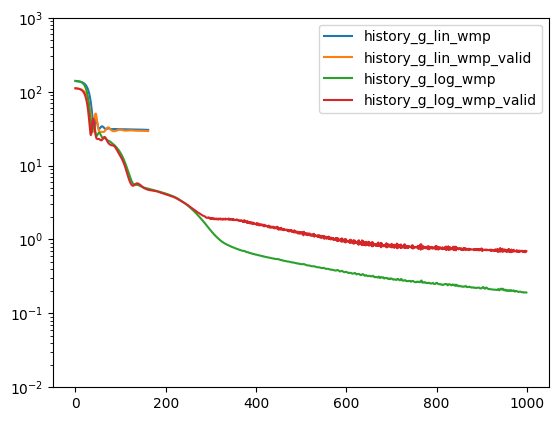

In [20]:
smr_model_g_lin_wmp, history_g_lin_wmp, history_valid_g_lin_wmp = train((Simple1DCNNwMP().double()).to(device), data_dict["LIN:S_MR+SAUG"].mr.loader_g,data_dict["LIN:S_MR+SAUG"].mr.tsr_valid_feat_g,data_dict["LIN:S_MR+SAUG"].mr.tsr_valid_lab_g,patience=100)
print()
smr_model_g_log_wmp, history_g_log_wmp, history_valid_g_log_wmp = train((Simple1DCNNwMP().double()).to(device), data_dict["LOG:S_MR+SAUG"].mr.loader_g,data_dict["LOG:S_MR+SAUG"].mr.tsr_valid_feat_g,data_dict["LOG:S_MR+SAUG"].mr.tsr_valid_lab_g,patience=100)
print()

plot(history_g_lin_wmp, history_valid_g_lin_wmp ,"history_g_lin_wmp")
plot(history_g_log_wmp, history_valid_g_log_wmp ,"history_g_log_wmp")

Epoch [1/1000], Loss: 137.6944 , Valid Loss: 109.3650 , TIME_DIFF: 0.014522075653076172 , RUNTIME: 0.014525651931762695
Epoch [101/1000], Loss: 31.0722 , Valid Loss: 30.0574 , TIME_DIFF: 2.4230425357818604 , RUNTIME: 2.437641143798828
Epoch [201/1000], Loss: 16.5963 , Valid Loss: 13.6129 , TIME_DIFF: 2.877413034439087 , RUNTIME: 5.315133810043335
Epoch [301/1000], Loss: 4.6190 , Valid Loss: 3.7056 , TIME_DIFF: 3.7445240020751953 , RUNTIME: 9.059727668762207
Epoch [401/1000], Loss: 2.5492 , Valid Loss: 2.2654 , TIME_DIFF: 3.1673696041107178 , RUNTIME: 12.227330684661865
Epoch [501/1000], Loss: 1.4210 , Valid Loss: 1.4505 , TIME_DIFF: 2.6306869983673096 , RUNTIME: 14.85808277130127
Epoch [601/1000], Loss: 0.9051 , Valid Loss: 1.0157 , TIME_DIFF: 3.4418928623199463 , RUNTIME: 18.300055980682373
Epoch [701/1000], Loss: 0.6143 , Valid Loss: 0.7584 , TIME_DIFF: 1.4090633392333984 , RUNTIME: 19.709189414978027
Epoch [801/1000], Loss: 0.4358 , Valid Loss: 0.5831 , TIME_DIFF: 1.624389886856079 

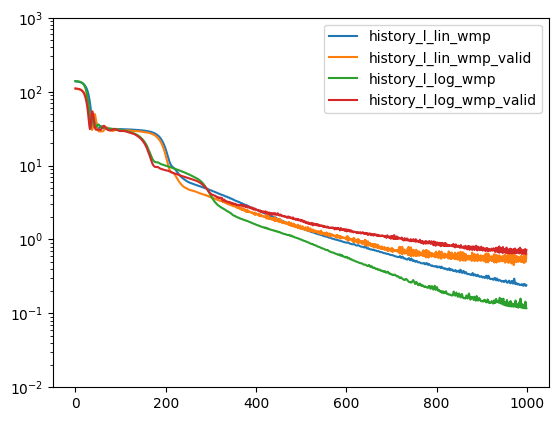

In [21]:
smr_model_l_lin_wmp, history_l_lin_wmp, history_valid_l_lin_wmp = train((Simple1DCNNwMP().double()).to(device), data_dict["LIN:S_MR+SAUG"].mr.loader_l,data_dict["LIN:S_MR+SAUG"].mr.tsr_valid_feat_l,data_dict["LIN:S_MR+SAUG"].mr.tsr_valid_lab_l,patience=100)
print()
smr_model_l_log_wmp, history_l_log_wmp, history_valid_l_log_wmp = train((Simple1DCNNwMP().double()).to(device), data_dict["LOG:S_MR+SAUG"].mr.loader_l,data_dict["LOG:S_MR+SAUG"].mr.tsr_valid_feat_l,data_dict["LOG:S_MR+SAUG"].mr.tsr_valid_lab_l,patience=100)
print()

plot(history_l_lin_wmp, history_valid_l_lin_wmp ,"history_l_lin_wmp")
plot(history_l_log_wmp, history_valid_l_log_wmp ,"history_l_log_wmp")


## PLOT AND TEST
TEST on R.DATA with MR

In [22]:
test_feat_g_lin = data_dict["LIN:S_MR+SAUG"].mr.normalize(data_dict["LIN:R_MR+SAUG"].mr.feature,"global")
test_lab_g_lin = data_dict["LIN:R_MR+SAUG"].mr.labels
test_feat_l_lin = data_dict["LIN:S_MR+SAUG"].mr.normalize(data_dict["LIN:R_MR+SAUG"].mr.feature,"local")
test_lab_l_lin = data_dict["LIN:R_MR+SAUG"].mr.labels

test_feat_g_log = data_dict["LOG:S_MR+SAUG"].mr.normalize(data_dict["LOG:R_MR+SAUG"].mr.feature,"global")
test_lab_g_log = data_dict["LOG:R_MR+SAUG"].mr.labels
test_feat_l_log = data_dict["LOG:S_MR+SAUG"].mr.normalize(data_dict["LOG:R_MR+SAUG"].mr.feature,"local")
test_lab_l_log = data_dict["LOG:R_MR+SAUG"].mr.labels

In [23]:
def test_one(m,h,hv,test_feat,test_lab,label,plotopt=False):
    print("____{}____".format(label))
    lastlost = []
    lastlostv = []
    testlostmu = []
    testlostsig = []
    testlost = []
    #print(h[-1][-1],hv[-1][-1])
    lastlost.append( h[-1][-1])
    lastlostv.append( hv[-1][-1])
    
    m.eval()
    with torch.no_grad():
        test_output = m(torch.DoubleTensor(test_feat).to(device))

    # Calculate the mean squared error (MSE) for regression evaluation
    mse_dim1 = nn.MSELoss()(test_output[:, 0], torch.DoubleTensor(test_lab).to(device)[:, 0])
    mse_dim2 = nn.MSELoss()(test_output[:, 1], torch.DoubleTensor(test_lab).to(device)[:, 1])
    mse      = nn.MSELoss()(test_output      , torch.DoubleTensor(test_lab).to(device))
    msetest = (mse_dim1 + mse_dim2)/2
    #print(mse_dim1.item(),mse_dim2.item(),msetest.item(),mse.item())
    testlostmu.append(mse_dim1.item())
    testlostsig.append(mse_dim2.item())
    testlost.append(mse.item())

    if plotopt:
        plt.plot(*np.transpose(h),label=label+"_"+str(i))
        plt.plot(*np.transpose(hv),label=label+"_val_"+str(i))

    print("train       : ", h[-1][-1]       ,label)
    print("Valid       : ", hv[-1][-1]      ,label)
    print("testlostmu  : ", mse_dim1.item() ,label)
    print("testlostsig : ", mse_dim2.item() ,label)
    print("testlost    : ", mse.item()      ,label)
    print()
    if plotopt:
        plt.yscale("log")
        plt.ylim(0.01,1000)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
    return lastlost, lastlostv,testlostmu,testlostsig,testlost
    
lastlost_smr_g_lin_wmp ,    lastlostv_smr_g_lin_wmp , testlostmu_smr_g_lin_wmp ,    testlostsig_smr_g_lin_wmp, testlost_smr_g_lin_wmp       = test_one(smr_model_g_lin_wmp, history_g_lin_wmp, history_valid_g_lin_wmp,test_feat_g_lin,test_lab_g_lin,"smr_g_lin_wmp")
lastlost_smr_g_log_wmp ,    lastlostv_smr_g_log_wmp , testlostmu_smr_g_log_wmp ,    testlostsig_smr_g_log_wmp, testlost_smr_g_log_wmp       = test_one(smr_model_g_log_wmp, history_g_log_wmp, history_valid_g_log_wmp,test_feat_g_log,test_lab_g_log,"smr_g_log_wmp")
lastlost_smr_l_lin_wmp ,    lastlostv_smr_l_lin_wmp , testlostmu_smr_l_lin_wmp ,    testlostsig_smr_l_lin_wmp, testlost_smr_l_lin_wmp       = test_one(smr_model_l_lin_wmp, history_l_lin_wmp, history_valid_l_lin_wmp,test_feat_l_lin,test_lab_l_lin,"smr_l_lin_wmp")
lastlost_smr_l_log_wmp ,    lastlostv_smr_l_log_wmp , testlostmu_smr_l_log_wmp ,    testlostsig_smr_l_log_wmp, testlost_smr_l_log_wmp       = test_one(smr_model_l_log_wmp, history_l_log_wmp, history_valid_l_log_wmp,test_feat_l_log,test_lab_l_log,"smr_l_log_wmp")





____smr_g_lin_wmp____
train       :  30.331788158788612 smr_g_lin_wmp
Valid       :  29.273209295145456 smr_g_lin_wmp
testlostmu  :  51.91201665361236 smr_g_lin_wmp
testlostsig :  1.160392714974284 smr_g_lin_wmp
testlost    :  26.536204684293324 smr_g_lin_wmp

____smr_g_log_wmp____
train       :  0.19110766435879878 smr_g_log_wmp
Valid       :  0.694068845017198 smr_g_log_wmp
testlostmu  :  0.781011589141137 smr_g_log_wmp
testlostsig :  0.08117936404671225 smr_g_log_wmp
testlost    :  0.4310954765939246 smr_g_log_wmp

____smr_l_lin_wmp____
train       :  0.239992539176826 smr_l_lin_wmp
Valid       :  0.630682054969077 smr_l_lin_wmp
testlostmu  :  0.38271773383210367 smr_l_lin_wmp
testlostsig :  0.25358346966473033 smr_l_lin_wmp
testlost    :  0.318150601748417 smr_l_lin_wmp

____smr_l_log_wmp____
train       :  0.11719423116937654 smr_l_log_wmp
Valid       :  0.7235876091957852 smr_l_log_wmp
testlostmu  :  0.6031374639993494 smr_l_log_wmp
testlostsig :  0.193072091634024 smr_l_log_wmp


# MODEL II : Multihead CNN(data) + MLP (Cuts)

In [24]:
# Define the 1D CNN
class CNNHead(nn.Module):
    def __init__(self):
        super(CNNHead, self).__init__()
        self.conv1   = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=5)#,padding=2)
        self.conv2   = torch.nn.Conv1d(in_channels=20, out_channels=2, kernel_size=1)#,padding=2)
        self.relu    = torch.nn.ReLU()
        self.linear1 = nn.Linear(192, 50)
        self.linear2 = nn.Linear(50, 10)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(x.size(0), -1)     
        x = self.relu(self.linear1(x))
        x = self.linear2(x)       
        
        
        return x
        
class CNNHeadwMP(torch.nn.Module):
    def __init__(self):
        super(CNNHeadwMP, self).__init__()
        self.conv1   = torch.nn.Conv1d(in_channels=1, out_channels=20, kernel_size=5)#,padding=2)
        self.conv2   = torch.nn.Conv1d(in_channels=20, out_channels=20, kernel_size=1)#,padding=2)
        self.conv3   = torch.nn.Conv1d(in_channels=20, out_channels=2, kernel_size=1)#,padding=2)
        self.maxpool = torch.nn.MaxPool1d(kernel_size=2)
        self.relu    = torch.nn.ReLU()
        self.linear1 = nn.Linear(240, 50)
        self.linear2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)     
        x = self.relu(self.linear1(x))
        x = self.linear2(x)                
        return x

# Define the MLP
class MLPHead(nn.Module):
    def __init__(self, input_size):
        super(MLPHead, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(10, 10)  # Output size 2 for the MLP

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define the model    
class MultiHeadModel(nn.Module):
    def __init__(self, mlp_input_size, hidden_size,wmp=False):
        super(MultiHeadModel, self).__init__()
        self.cnn_head = CNNHead()
        self.cnn_headwmp = CNNHeadwMP()
        self.mlp_head = MLPHead(mlp_input_size)
        self.wmp = wmp
        
        # Additional hidden layers
        self.hidden1 = nn.Linear(20, hidden_size)
        self.relu = nn.ReLU()
        self.hiddenhidden = nn.Linear(hidden_size, hidden_size)
        self.hidden2 = nn.Linear(hidden_size, 10)

        # Output layer
        self.output_layer = nn.Linear(10, 2)  # Output size 2 for final predictions

    def forward(self, x_cnn, x_mlp):
        if self.wmp:
            cnn_output = self.cnn_headwmp(x_cnn)
        else:    
            cnn_output = self.cnn_head(x_cnn)
        mlp_output = self.mlp_head(x_mlp)
        
        # Concatenate the outputs from both heads
        concatenated = torch.cat((cnn_output, mlp_output.squeeze(dim=1)), dim=1)
        
        # Pass through additional hidden layers
        hidden1_output = self.relu(self.hidden1(concatenated))
        hidden1_output = self.relu(self.hiddenhidden(hidden1_output))
        hidden1_output = self.relu(self.hiddenhidden(hidden1_output))
        hidden2_output = self.relu(self.hidden2(hidden1_output))
        
        # Final predictions
        final_output = self.output_layer(hidden2_output)
        return final_output


In [25]:
def train_waux(model,mydata,norm,fullaux,nepochs = 1000 ,patience=10):
    
    if norm == "local":
        if fullaux:
            loader              = mydata.loader_l_waux        
            valid_aux_tnsr      = mydata.tsr_valid_aux_l
            valid_aux_tnsr_mr   = mydata.mr.tsr_norm_aux
        else:
            loader              = mydata.loader_l_wcuts        
            valid_aux_tnsr      = mydata.tsr_valid_cuts_l
            valid_aux_tnsr_mr   = mydata.mr.tsr_norm_cuts
        
        valid_feat_tnsr     = mydata.tsr_valid_feat_l
        valid_lab_tnsr      = mydata.tsr_valid_lab_l
        valid_feat_tnsr_mr  = torch.DoubleTensor(mydata.normalize(mydata.mr.feature,"local")).to(device)
        valid_lab_tnsr_mr   = mydata.mr.tsr_labels

    elif norm == "global":
        if fullaux:
            loader              = mydata.loader_g_waux        
            valid_aux_tnsr      = mydata.tsr_valid_aux_g
            valid_aux_tnsr_mr   = mydata.mr.tsr_norm_aux
        else:
            loader              = mydata.loader_l_wcuts        
            valid_aux_tnsr      = mydata.tsr_valid_cuts_l
            valid_aux_tnsr_mr   = mydata.mr.tsr_norm_cuts
        
        valid_feat_tnsr         = mydata.tsr_valid_feat_g
        valid_lab_tnsr          = mydata.tsr_valid_lab_g
        valid_feat_tnsr_mr      = torch.DoubleTensor(mydata.normalize(mydata.mr.feature,"global")).to(device)
        valid_lab_tnsr_mr       = mydata.mr.tsr_labels
    else:
        raise ValueError


    start = time.time()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    history_valid = []
    history_valid_mr = []
    history = []
    best_val_loss = float('inf')
    printslice = nepochs/100
    if nepochs/100 < 1:
        printslice = 1
    for epoch in range(nepochs):

        # Train the model for one epoch
        model.train()
        average_loss = 0
        for image_batch, input_batch,labels in loader:
            optimizer.zero_grad()
            outputs = model(image_batch,input_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            average_loss += loss.item()

        average_loss = average_loss / len(loader)    


        # Evaluate the model on the valid set
        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_feat_tnsr,valid_aux_tnsr)
            valid_outputs_mr = model(valid_feat_tnsr_mr,valid_aux_tnsr_mr)

            # Calculate the mean squared error (MSE) for regression evaluation
            mse_dim1 = nn.MSELoss()(valid_outputs[:, 0], valid_lab_tnsr[:, 0])
            mse_dim2 = nn.MSELoss()(valid_outputs[:, 1], valid_lab_tnsr[:, 1])
            valid_loss = (mse_dim1 + mse_dim2)/2
        
            # Calculate the mean squared error (MSE) for regression evaluation
            mse_dim1_mr = nn.MSELoss()(valid_outputs_mr[:, 0], valid_lab_tnsr_mr[:, 0])
            mse_dim2_mr = nn.MSELoss()(valid_outputs_mr[:, 1], valid_lab_tnsr_mr[:, 1])
            valid_loss_mr = (mse_dim1_mr + mse_dim2_mr)/2
    

        # Save the loss history
        history.append([epoch,average_loss])
        history_valid.append([epoch,float(valid_loss)])
        history_valid_mr.append([epoch,float(valid_loss_mr)])

        if epoch % int(printslice) == 0:
            if epoch == 0:
                ltime = start
            print(f'Epoch [{epoch+1}/{nepochs}], Loss: {average_loss:.4f} , Valid Loss: {valid_loss:.4f}, Valid Loss @ MR: {valid_loss_mr:.4f}, TIME_DIFF: {time.time()-ltime} , RUNTIME: {time.time()-start}')
            ltime = time.time()

        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            current_patience = 0
        else:
            #print(valid_loss,best_val_loss)
            current_patience += 1

        # Early stopping check
        if current_patience >= patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping at {epoch}...')
            break    
    end = time.time()
    print("took {} seconds".format(end-start))
    return model,history,history_valid,history_valid_mr
    
def plot_more(history,history_v,history_vmr,label):
    plt.plot(*np.transpose(history),label=label)
    plt.plot(*np.transpose(history_v),label=label+"_valid")
    plt.plot(*np.transpose(history_vmr),label=label+"_mr_valid")
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.yscale("log")
    plt.ylim(0.01,1000)

Epoch [1/1000], Loss: 131.7382 , Valid Loss: 128.4585, Valid Loss @ MR: 129.7495, TIME_DIFF: 0.5108373165130615 , RUNTIME: 0.5108416080474854
Epoch [11/1000], Loss: 26.3433 , Valid Loss: 30.9895, Valid Loss @ MR: 30.8335, TIME_DIFF: 6.939431428909302 , RUNTIME: 7.450516223907471
Epoch [21/1000], Loss: 21.4685 , Valid Loss: 27.9282, Valid Loss @ MR: 28.1991, TIME_DIFF: 6.4885852336883545 , RUNTIME: 13.93916630744934
Epoch [31/1000], Loss: 20.0811 , Valid Loss: 26.3149, Valid Loss @ MR: 26.7359, TIME_DIFF: 6.107672214508057 , RUNTIME: 20.046907901763916
Epoch [41/1000], Loss: 19.2617 , Valid Loss: 25.5279, Valid Loss @ MR: 25.0862, TIME_DIFF: 5.935459136962891 , RUNTIME: 25.98246669769287
Epoch [51/1000], Loss: 17.9644 , Valid Loss: 24.3049, Valid Loss @ MR: 21.2991, TIME_DIFF: 10.491450071334839 , RUNTIME: 36.47398018836975
Epoch [61/1000], Loss: 16.6085 , Valid Loss: 22.9219, Valid Loss @ MR: 16.1365, TIME_DIFF: 5.541934251785278 , RUNTIME: 42.01602101325989
Epoch [71/1000], Loss: 15.4

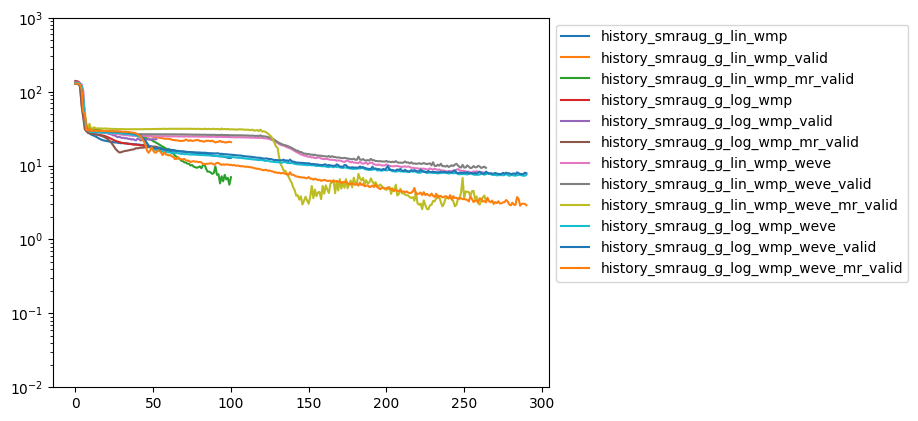

In [26]:
smraug_model_g_lin_wmp, history_smraug_g_lin_wmp, history_smraug_valid_g_lin_wmp , history_smraug_valid_mr_g_lin_wmp                      = train_waux((MultiHeadModel(2, 64,True).double()).to(device), data_dict['LIN:S_MR+SAUG'],"global",False)
smraug_model_g_lin_wmp_weve, history_smraug_g_lin_wmp_weve, history_smraug_valid_g_lin_wmp_weve , history_smraug_valid_mr_g_lin_wmp_weve  = train_waux((MultiHeadModel(3, 64,True).double()).to(device), data_dict['LIN:S_MR+SAUG'],"global",True)
smraug_model_g_log_wmp, history_smraug_g_log_wmp, history_smraug_valid_g_log_wmp , history_smraug_valid_mr_g_log_wmp                      = train_waux((MultiHeadModel(2, 64,True).double()).to(device), data_dict['LOG:S_MR+SAUG'],"global",False)
smraug_model_g_log_wmp_weve, history_smraug_g_log_wmp_weve, history_smraug_valid_g_log_wmp_weve , history_smraug_valid_mr_g_log_wmp_weve  = train_waux((MultiHeadModel(3, 64,True).double()).to(device), data_dict['LOG:S_MR+SAUG'],"global",True)
plot_more(history_smraug_g_lin_wmp,history_smraug_valid_g_lin_wmp, history_smraug_valid_mr_g_lin_wmp,"history_smraug_g_lin_wmp")
plot_more(history_smraug_g_log_wmp,history_smraug_valid_g_log_wmp, history_smraug_valid_mr_g_log_wmp,"history_smraug_g_log_wmp")
plot_more(history_smraug_g_lin_wmp_weve,history_smraug_valid_g_lin_wmp_weve, history_smraug_valid_mr_g_lin_wmp_weve,"history_smraug_g_lin_wmp_weve")
plot_more(history_smraug_g_log_wmp_weve,history_smraug_valid_g_log_wmp_weve, history_smraug_valid_mr_g_log_wmp_weve,"history_smraug_g_log_wmp_weve")
plt.show()
    

Epoch [1/1000], Loss: 131.4545 , Valid Loss: 127.5918, Valid Loss @ MR: 128.9684, TIME_DIFF: 0.3594529628753662 , RUNTIME: 0.35945749282836914
Epoch [11/1000], Loss: 26.4755 , Valid Loss: 26.5313, Valid Loss @ MR: 31.3545, TIME_DIFF: 3.0759758949279785 , RUNTIME: 3.4355106353759766
Epoch [21/1000], Loss: 22.5667 , Valid Loss: 23.0545, Valid Loss @ MR: 30.4162, TIME_DIFF: 3.084540605545044 , RUNTIME: 6.520297288894653
Epoch [31/1000], Loss: 20.3048 , Valid Loss: 21.6739, Valid Loss @ MR: 27.0813, TIME_DIFF: 3.50465989112854 , RUNTIME: 10.025032043457031
Epoch [41/1000], Loss: 19.7301 , Valid Loss: 21.2019, Valid Loss @ MR: 25.7581, TIME_DIFF: 3.4311349391937256 , RUNTIME: 13.456420421600342
Epoch [51/1000], Loss: 18.9426 , Valid Loss: 20.4773, Valid Loss @ MR: 24.0244, TIME_DIFF: 3.2165281772613525 , RUNTIME: 16.67323327064514
Epoch [61/1000], Loss: 17.9777 , Valid Loss: 19.3133, Valid Loss @ MR: 21.3895, TIME_DIFF: 3.274066686630249 , RUNTIME: 19.947574615478516
Epoch [71/1000], Loss: 

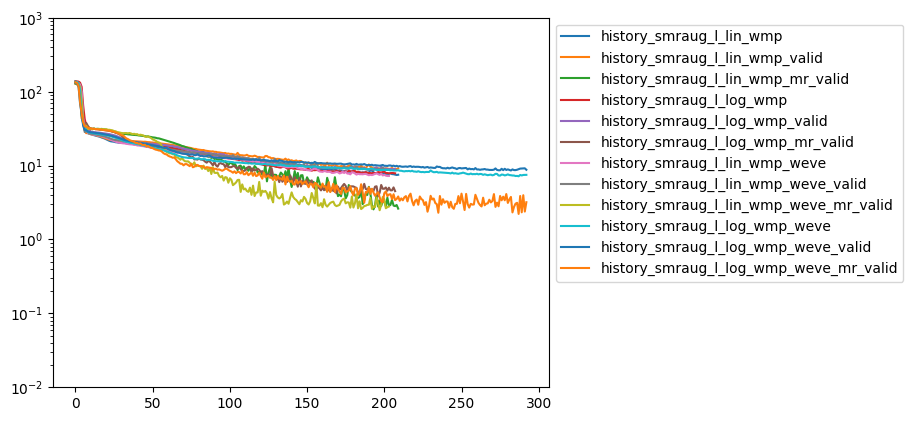

In [27]:
smraug_model_l_lin_wmp, history_smraug_l_lin_wmp, history_smraug_valid_l_lin_wmp , history_smraug_valid_mr_l_lin_wmp = train_waux((MultiHeadModel(2, 64,True).double()).to(device), data_dict['LIN:S_MR+SAUG'],"local",False)
smraug_model_l_lin_wmp_weve, history_smraug_l_lin_wmp_weve, history_smraug_valid_l_lin_wmp_weve , history_smraug_valid_mr_l_lin_wmp_weve = train_waux((MultiHeadModel(3, 64,True).double()).to(device), data_dict['LIN:S_MR+SAUG'],"local",True)
smraug_model_l_log_wmp, history_smraug_l_log_wmp, history_smraug_valid_l_log_wmp , history_smraug_valid_mr_l_log_wmp = train_waux((MultiHeadModel(2, 64,True).double()).to(device), data_dict['LOG:S_MR+SAUG'],"local",False)
smraug_model_l_log_wmp_weve, history_smraug_l_log_wmp_weve, history_smraug_valid_l_log_wmp_weve , history_smraug_valid_mr_l_log_wmp_weve = train_waux((MultiHeadModel(3, 64,True).double()).to(device), data_dict['LOG:S_MR+SAUG'],"local",True)
plot_more(history_smraug_l_lin_wmp,history_smraug_valid_l_lin_wmp, history_smraug_valid_mr_l_lin_wmp,"history_smraug_l_lin_wmp")
plot_more(history_smraug_l_log_wmp,history_smraug_valid_l_log_wmp, history_smraug_valid_mr_l_log_wmp,"history_smraug_l_log_wmp")
plot_more(history_smraug_l_lin_wmp_weve,history_smraug_valid_l_lin_wmp_weve, history_smraug_valid_mr_l_lin_wmp_weve,"history_smraug_l_lin_wmp_weve")
plot_more(history_smraug_l_log_wmp_weve,history_smraug_valid_l_log_wmp_weve, history_smraug_valid_mr_l_log_wmp_weve,"history_smraug_l_log_wmp_weve")
plt.show()
    

Test

In [28]:
def test_one_multichannel(m,h,hv,hvmr,normalize_func,norm,feature,tsr_cuts,tsr_label,label,plotopt=False):
    test_feat = normalize_func(feature,norm)

    print("____{}____".format(label))
    lastlost       = []
    lastlostv      = []
    lastlostv_mr   = []
    testlostmu     = []
    testlostsig    = []
    testlost       = []

    lastlost.append(h[-1][-1])
    lastlostv.append(hv[-1][-1])
    lastlostv_mr.append(hvmr[-1][-1])
    m.eval()
    with torch.no_grad():
        test_output = m(torch.DoubleTensor(test_feat).to(device),tsr_cuts)
#        for i,j in zip(test_output      , tsr_label):
#            print(i,j)
    # Calculate the mean squared error (MSE) for regression evaluation
    mse_dim1 = nn.MSELoss()(test_output[:, 0], tsr_label[:, 0])
    mse_dim2 = nn.MSELoss()(test_output[:, 1], tsr_label[:, 1])
    mse      = nn.MSELoss()(test_output      , tsr_label)
    msetest = (mse_dim1 + mse_dim2)/2
    #print(mse_dim1.item(),mse_dim2.item(),msetest.item(),mse.item())

    testlostmu.append(mse_dim1.item())
    testlostsig.append(mse_dim2.item())
    testlost.append(mse.item())
    if plotopt:
        plt.plot(*np.transpose(h),label=label+"_"+str(i))
        plt.plot(*np.transpose(hv),label=label+"_val_"+str(i))
        plt.plot(*np.transpose(hvmr),label=label+"_valmr_"+str(i))

    print("train       : ",h[-1][-1]          ,label)
    print("Valid       : ",hv[-1][-1]         ,label)
    print("Valid  MR   : ",hvmr[-1][-1]       ,label)
    print("testlostmu  : ",mse_dim1.item()    ,label)
    print("testlostsig : ",mse_dim2.item()    ,label)
    print("testlost    : ",mse.item()         ,label)
    print()

    if plotopt:
        plt.yscale("log")
        plt.ylim(0.01,1000)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.show()
    
test_one_multichannel(smraug_model_g_lin_wmp, history_smraug_g_lin_wmp, history_smraug_valid_g_lin_wmp , history_smraug_valid_mr_g_lin_wmp , data_dict['LIN:S_MR+SAUG'].normalize,"global",data_dict['LIN:R_MR+SAUG'].mr.feature,data_dict['LIN:R_MR+SAUG'].mr.tsr_norm_cuts,data_dict['LIN:R_MR+SAUG'].mr.tsr_labels,"smraug_g_lin_wmp")
test_one_multichannel(smraug_model_g_log_wmp, history_smraug_g_log_wmp, history_smraug_valid_g_log_wmp , history_smraug_valid_mr_g_log_wmp , data_dict['LOG:S_MR+SAUG'].normalize,"global",data_dict['LOG:R_MR+SAUG'].mr.feature,data_dict['LOG:R_MR+SAUG'].mr.tsr_norm_cuts,data_dict['LOG:R_MR+SAUG'].mr.tsr_labels,"smraug_g_log_wmp")
test_one_multichannel(smraug_model_l_lin_wmp, history_smraug_l_lin_wmp, history_smraug_valid_l_lin_wmp , history_smraug_valid_mr_l_lin_wmp , data_dict['LIN:S_MR+SAUG'].normalize,"local",data_dict['LIN:R_MR+SAUG'].mr.feature,data_dict['LIN:R_MR+SAUG'].mr.tsr_norm_cuts,data_dict['LIN:R_MR+SAUG'].mr.tsr_labels,"smraug_l_lin_wmp")
test_one_multichannel(smraug_model_l_log_wmp, history_smraug_l_log_wmp, history_smraug_valid_l_log_wmp , history_smraug_valid_mr_l_log_wmp , data_dict['LOG:S_MR+SAUG'].normalize,"local",data_dict['LOG:R_MR+SAUG'].mr.feature,data_dict['LOG:R_MR+SAUG'].mr.tsr_norm_cuts,data_dict['LOG:R_MR+SAUG'].mr.tsr_labels,"smraug_l_log_wmp")

test_one_multichannel(smraug_model_g_lin_wmp_weve, history_smraug_g_lin_wmp_weve, history_smraug_valid_g_lin_wmp_weve , history_smraug_valid_mr_g_lin_wmp_weve      , data_dict['LIN:S_MR+SAUG'].normalize,"global",data_dict['LIN:R_MR+SAUG'].mr.feature,data_dict['LIN:R_MR+SAUG'].mr.tsr_norm_aux,data_dict['LIN:R_MR+SAUG'].mr.tsr_labels,"smraug_g_lin_wmp_weve")
test_one_multichannel(smraug_model_g_log_wmp_weve, history_smraug_g_log_wmp_weve, history_smraug_valid_g_log_wmp_weve , history_smraug_valid_mr_g_log_wmp_weve      , data_dict['LOG:S_MR+SAUG'].normalize,"global",data_dict['LOG:R_MR+SAUG'].mr.feature,data_dict['LOG:R_MR+SAUG'].mr.tsr_norm_aux,data_dict['LOG:R_MR+SAUG'].mr.tsr_labels,"smraug_g_log_wmp_weve")
test_one_multichannel(smraug_model_l_lin_wmp_weve, history_smraug_l_lin_wmp_weve, history_smraug_valid_l_lin_wmp_weve , history_smraug_valid_mr_l_lin_wmp_weve      , data_dict['LIN:S_MR+SAUG'].normalize,"local",data_dict['LIN:R_MR+SAUG'].mr.feature,data_dict['LIN:R_MR+SAUG'].mr.tsr_norm_aux,data_dict['LIN:R_MR+SAUG'].mr.tsr_labels,"smraug_l_lin_wmp_weve")
test_one_multichannel(smraug_model_l_log_wmp_weve, history_smraug_l_log_wmp_weve, history_smraug_valid_l_log_wmp_weve , history_smraug_valid_mr_l_log_wmp_weve      , data_dict['LOG:S_MR+SAUG'].normalize,"local",data_dict['LOG:R_MR+SAUG'].mr.feature,data_dict['LOG:R_MR+SAUG'].mr.tsr_norm_aux,data_dict['LOG:R_MR+SAUG'].mr.tsr_labels,"smraug_l_log_wmp_weve")


____smraug_g_lin_wmp____
train       :  12.680800196947368 smraug_g_lin_wmp
Valid       :  20.70626230999195 smraug_g_lin_wmp
Valid  MR   :  6.95311457620844 smraug_g_lin_wmp
testlostmu  :  10.455697049111974 smraug_g_lin_wmp
testlostsig :  1.3738489861077434 smraug_g_lin_wmp
testlost    :  5.914773017609859 smraug_g_lin_wmp

____smraug_g_log_wmp____
train       :  17.27688932943937 smraug_g_log_wmp
Valid       :  22.776417789464976 smraug_g_log_wmp
Valid  MR   :  17.946780999851157 smraug_g_log_wmp
testlostmu  :  27.976952841672563 smraug_g_log_wmp
testlostsig :  1.4497011835006248 smraug_g_log_wmp
testlost    :  14.713327012586596 smraug_g_log_wmp

____smraug_l_lin_wmp____
train       :  7.501048220887022 smraug_l_lin_wmp
Valid       :  9.15596881767503 smraug_l_lin_wmp
Valid  MR   :  2.611960691780066 smraug_l_lin_wmp
testlostmu  :  2.423422596153921 smraug_l_lin_wmp
testlostsig :  1.2383073527866326 smraug_l_lin_wmp
testlost    :  1.830864974470277 smraug_l_lin_wmp

____smraug_l_lo

Conclusion: Data Augmentation via SR improve training